# LRP explanations for ML Synergy Models
Implemented using zennit: https://github.com/chr5tphr/zennit

In [1]:
#! pip install zennit

In [2]:
import os

os.chdir(os.path.abspath(os.path.join(os.getcwd(), "../..")))
print(os.getcwd())

c:\Users\ismyn\UNI\FU Berlin\SWP_Cancer\Drug-Inhibitor-Cancer-Treatment


We need to find the right rule for each model layer, let's examine it first

In [3]:
from explainability.utils import load_transynergy_model, load_biomining_model

model_trans = load_transynergy_model("external/drug_combination/trans_synergy/data/models/fold_test_model.pt") 
model_biomining = load_biomining_model("external/predicting_synergy_nn/outputs/models/best_f1.pt")

## Biomining

See "Biomining" paper: https://biodatamining.biomedcentral.com/articles/10.1186/s13040-024-00359-z

We apply **LRP rules** only to the **Linear** layers. BatchNorm layers are handled using `SequentialMergeBatchNorm`. **ReLU** activations are **ignored**, as indicated in the [Zennit documentation](https://zennit.readthedocs.io/en/0.4.4/how-to/use-rules-composites-and-canonizers.html).

For the LRP rules used in the Linear layers, we follow the methodology described in [this paper](https://iphome.hhi.de/samek/pdf/MonXAI19.pdf). Specifically:

- **Top layers**: `LRP-0`
- **Middle layers**: `LRP-ε`
- **Bottom layer**: `LRP-γ`
- **Input layer**: `ZBox` rule

These choices are made in accordance with the recommendations provided in the literature.


### "Biomining"  Model architecture

In [4]:
print(model_biomining)

SynergyModel(
  (net): Sequential(
    (0): Linear(in_features=33, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=256, bias=True)
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=256, out_features=512, bias=True)
    (17): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, trac

## Explainations LRP for Biomining


In [5]:
import numpy as np
from explainability.data_utils import load_biomining_cell_line_data, load_biomining_data, load_biomining_drug_names
from explainability.explaination_config import ExplainationConfig

config = ExplainationConfig(
    paper="biomining",
)
cell_line_data = load_biomining_cell_line_data(split = 'test')
cell_line_data = np.concatenate([cell_line_data, cell_line_data], axis=0)
drug_name_a, drug_name_b = load_biomining_drug_names(split= 'test')
X, Y = load_biomining_data(split = 'test')

relevances = np.load("explainability/lrp/results/biomining_subsample_False/relevances.npy")
feature_names = config.feature_names


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Something strange is happening in the plots below.

You can see that the **same features from Drug A and Drug B do not hold the same relevance**, even though the prediction scores for the datapoints  
`(DRUG_A, DRUG_B, CELL_LINE)` and `(DRUG_B, DRUG_A, CELL_LINE)` are **averaged**.

This suggests an inconsistency in how feature relevance is attributed, despite the symmetry in scoring.


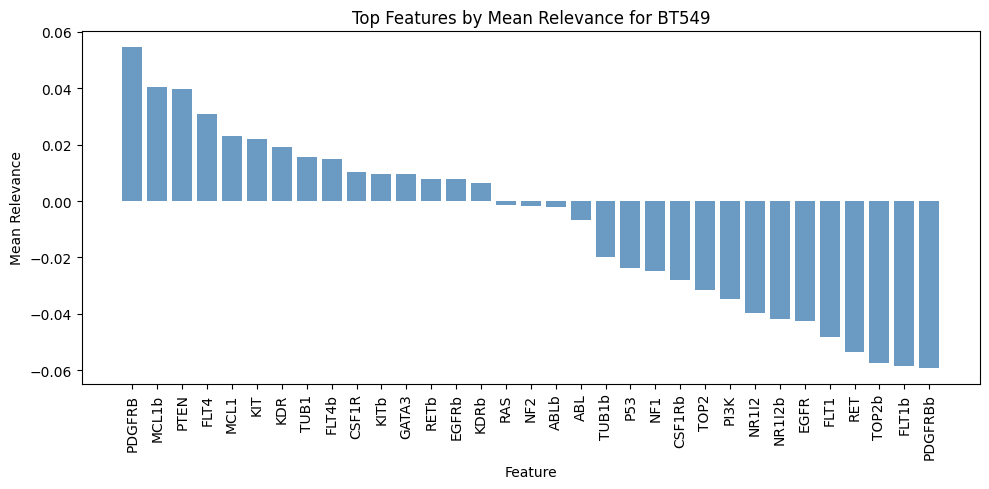

Number of samples for BT549: 6412


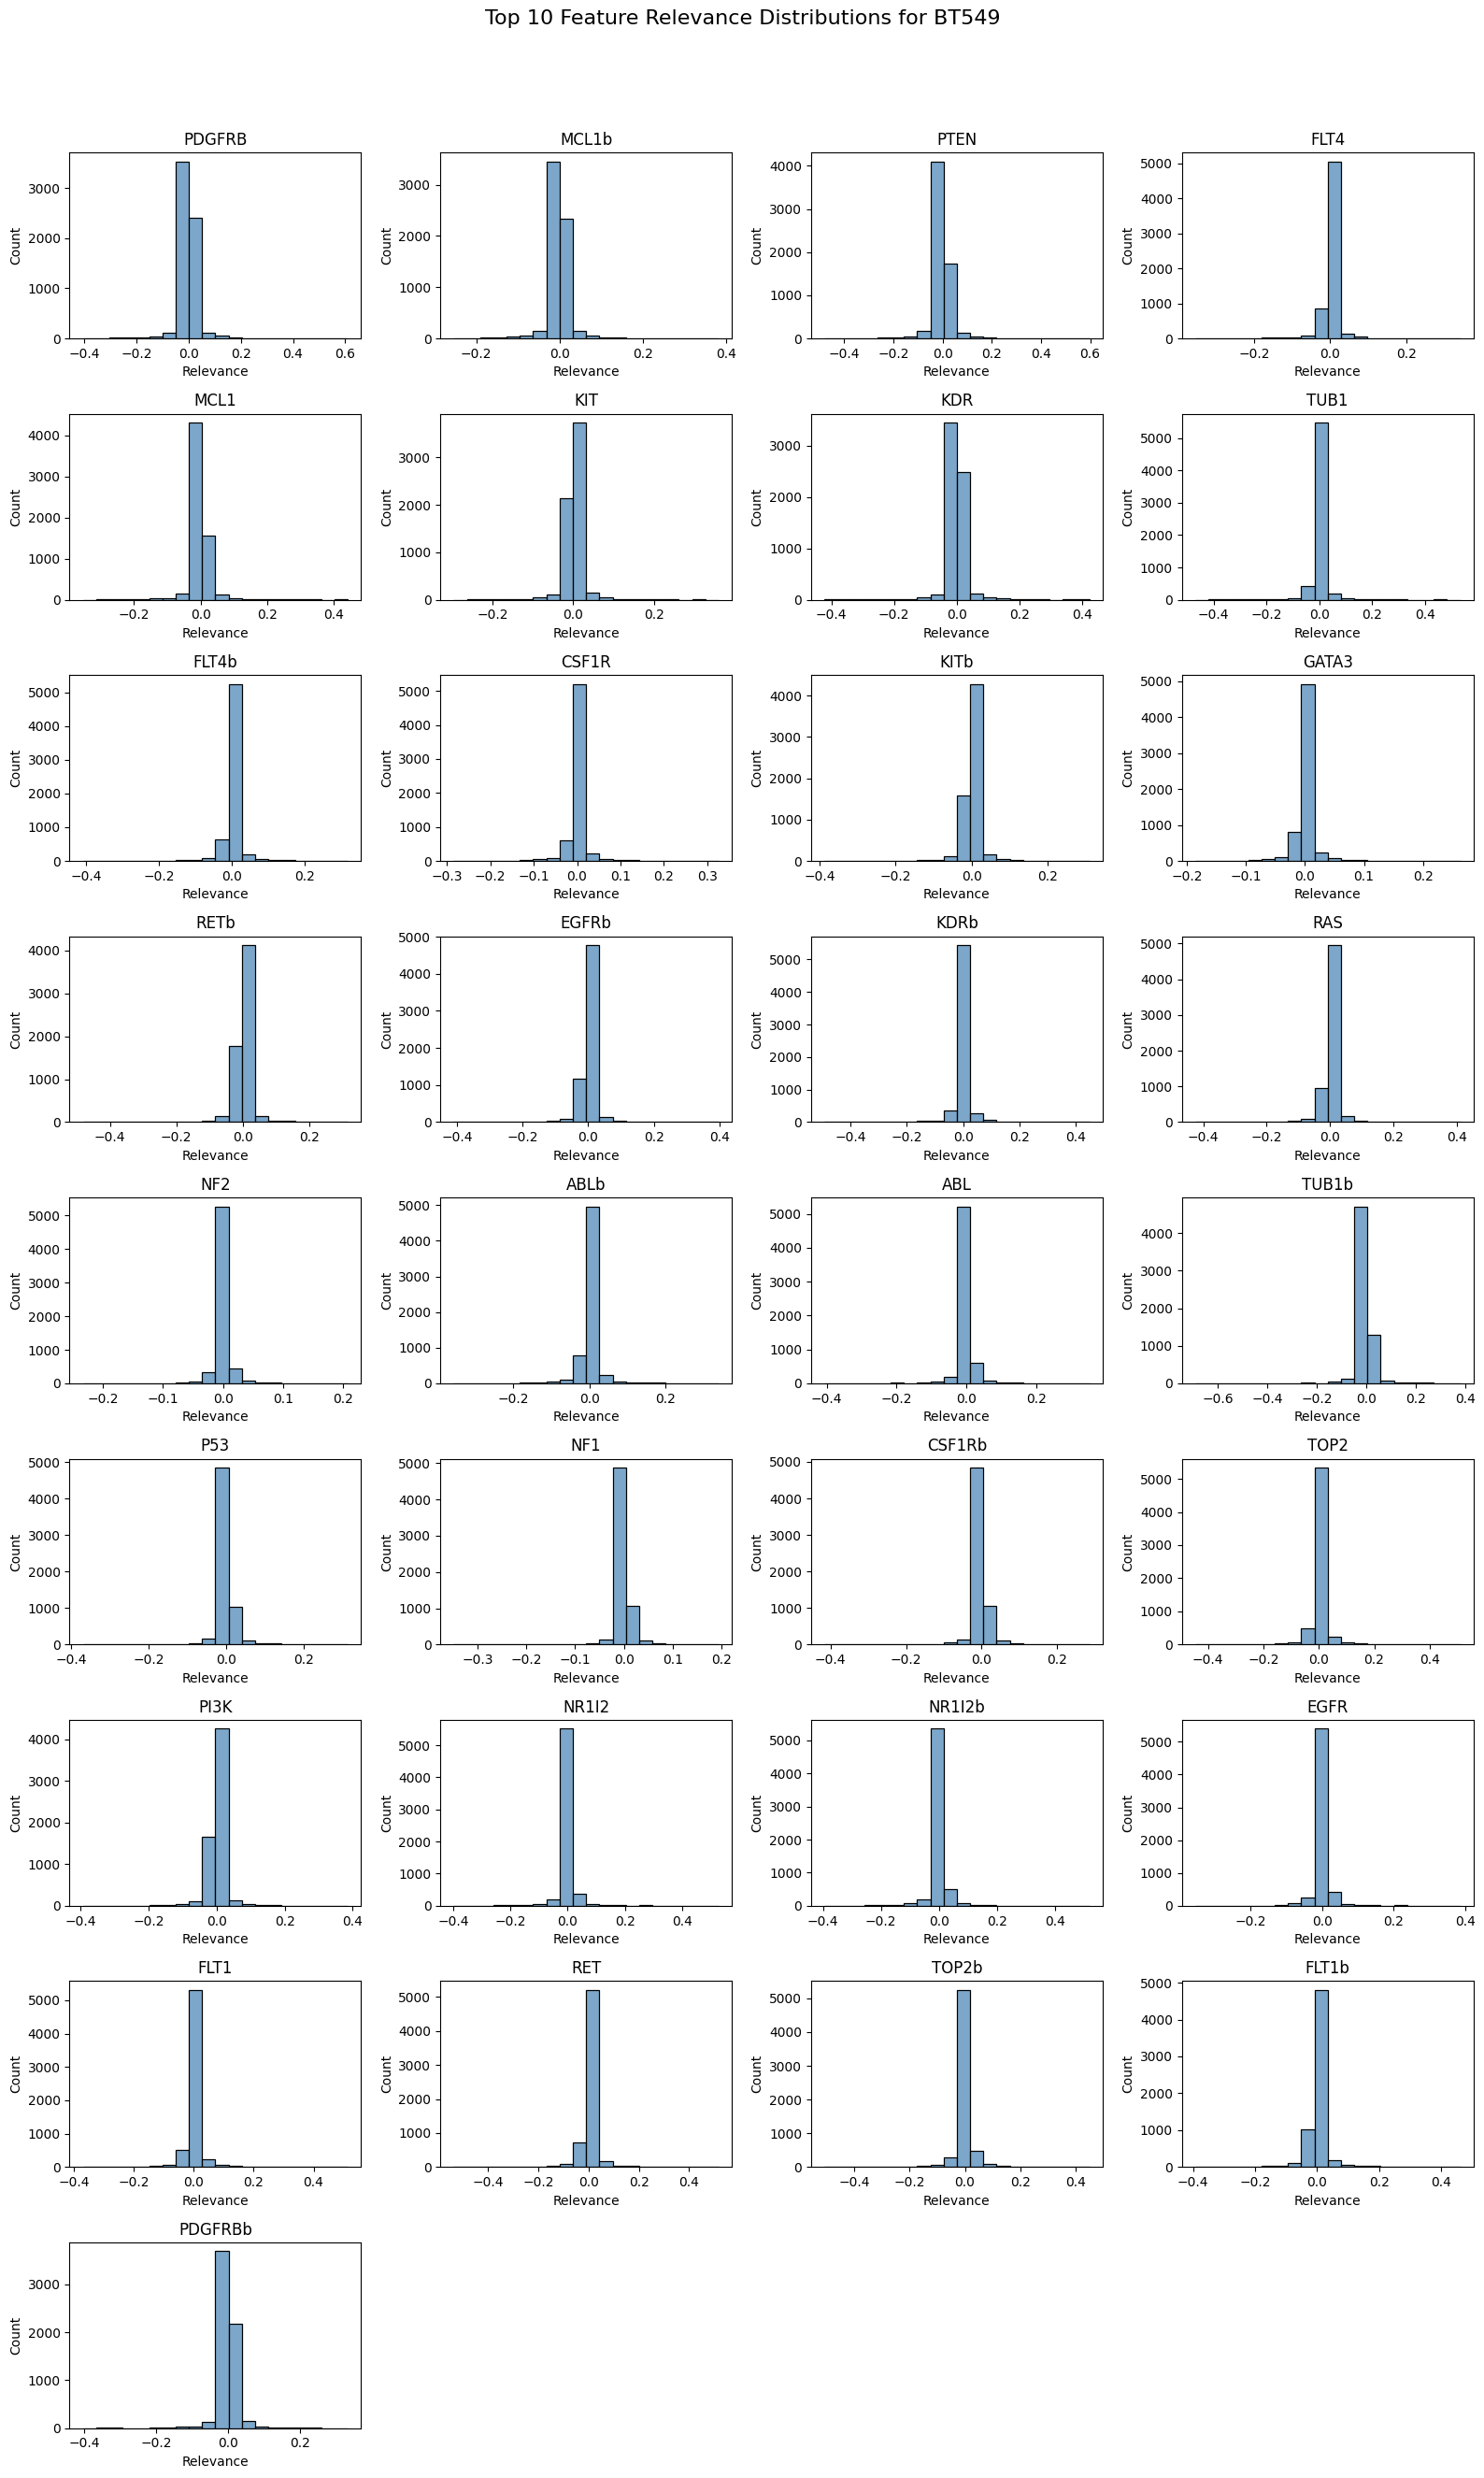

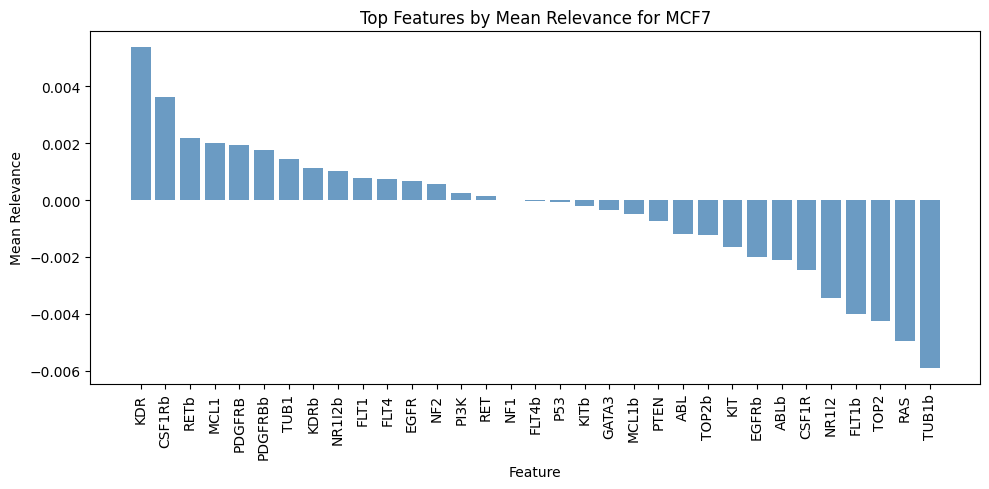

Number of samples for MCF7: 6484


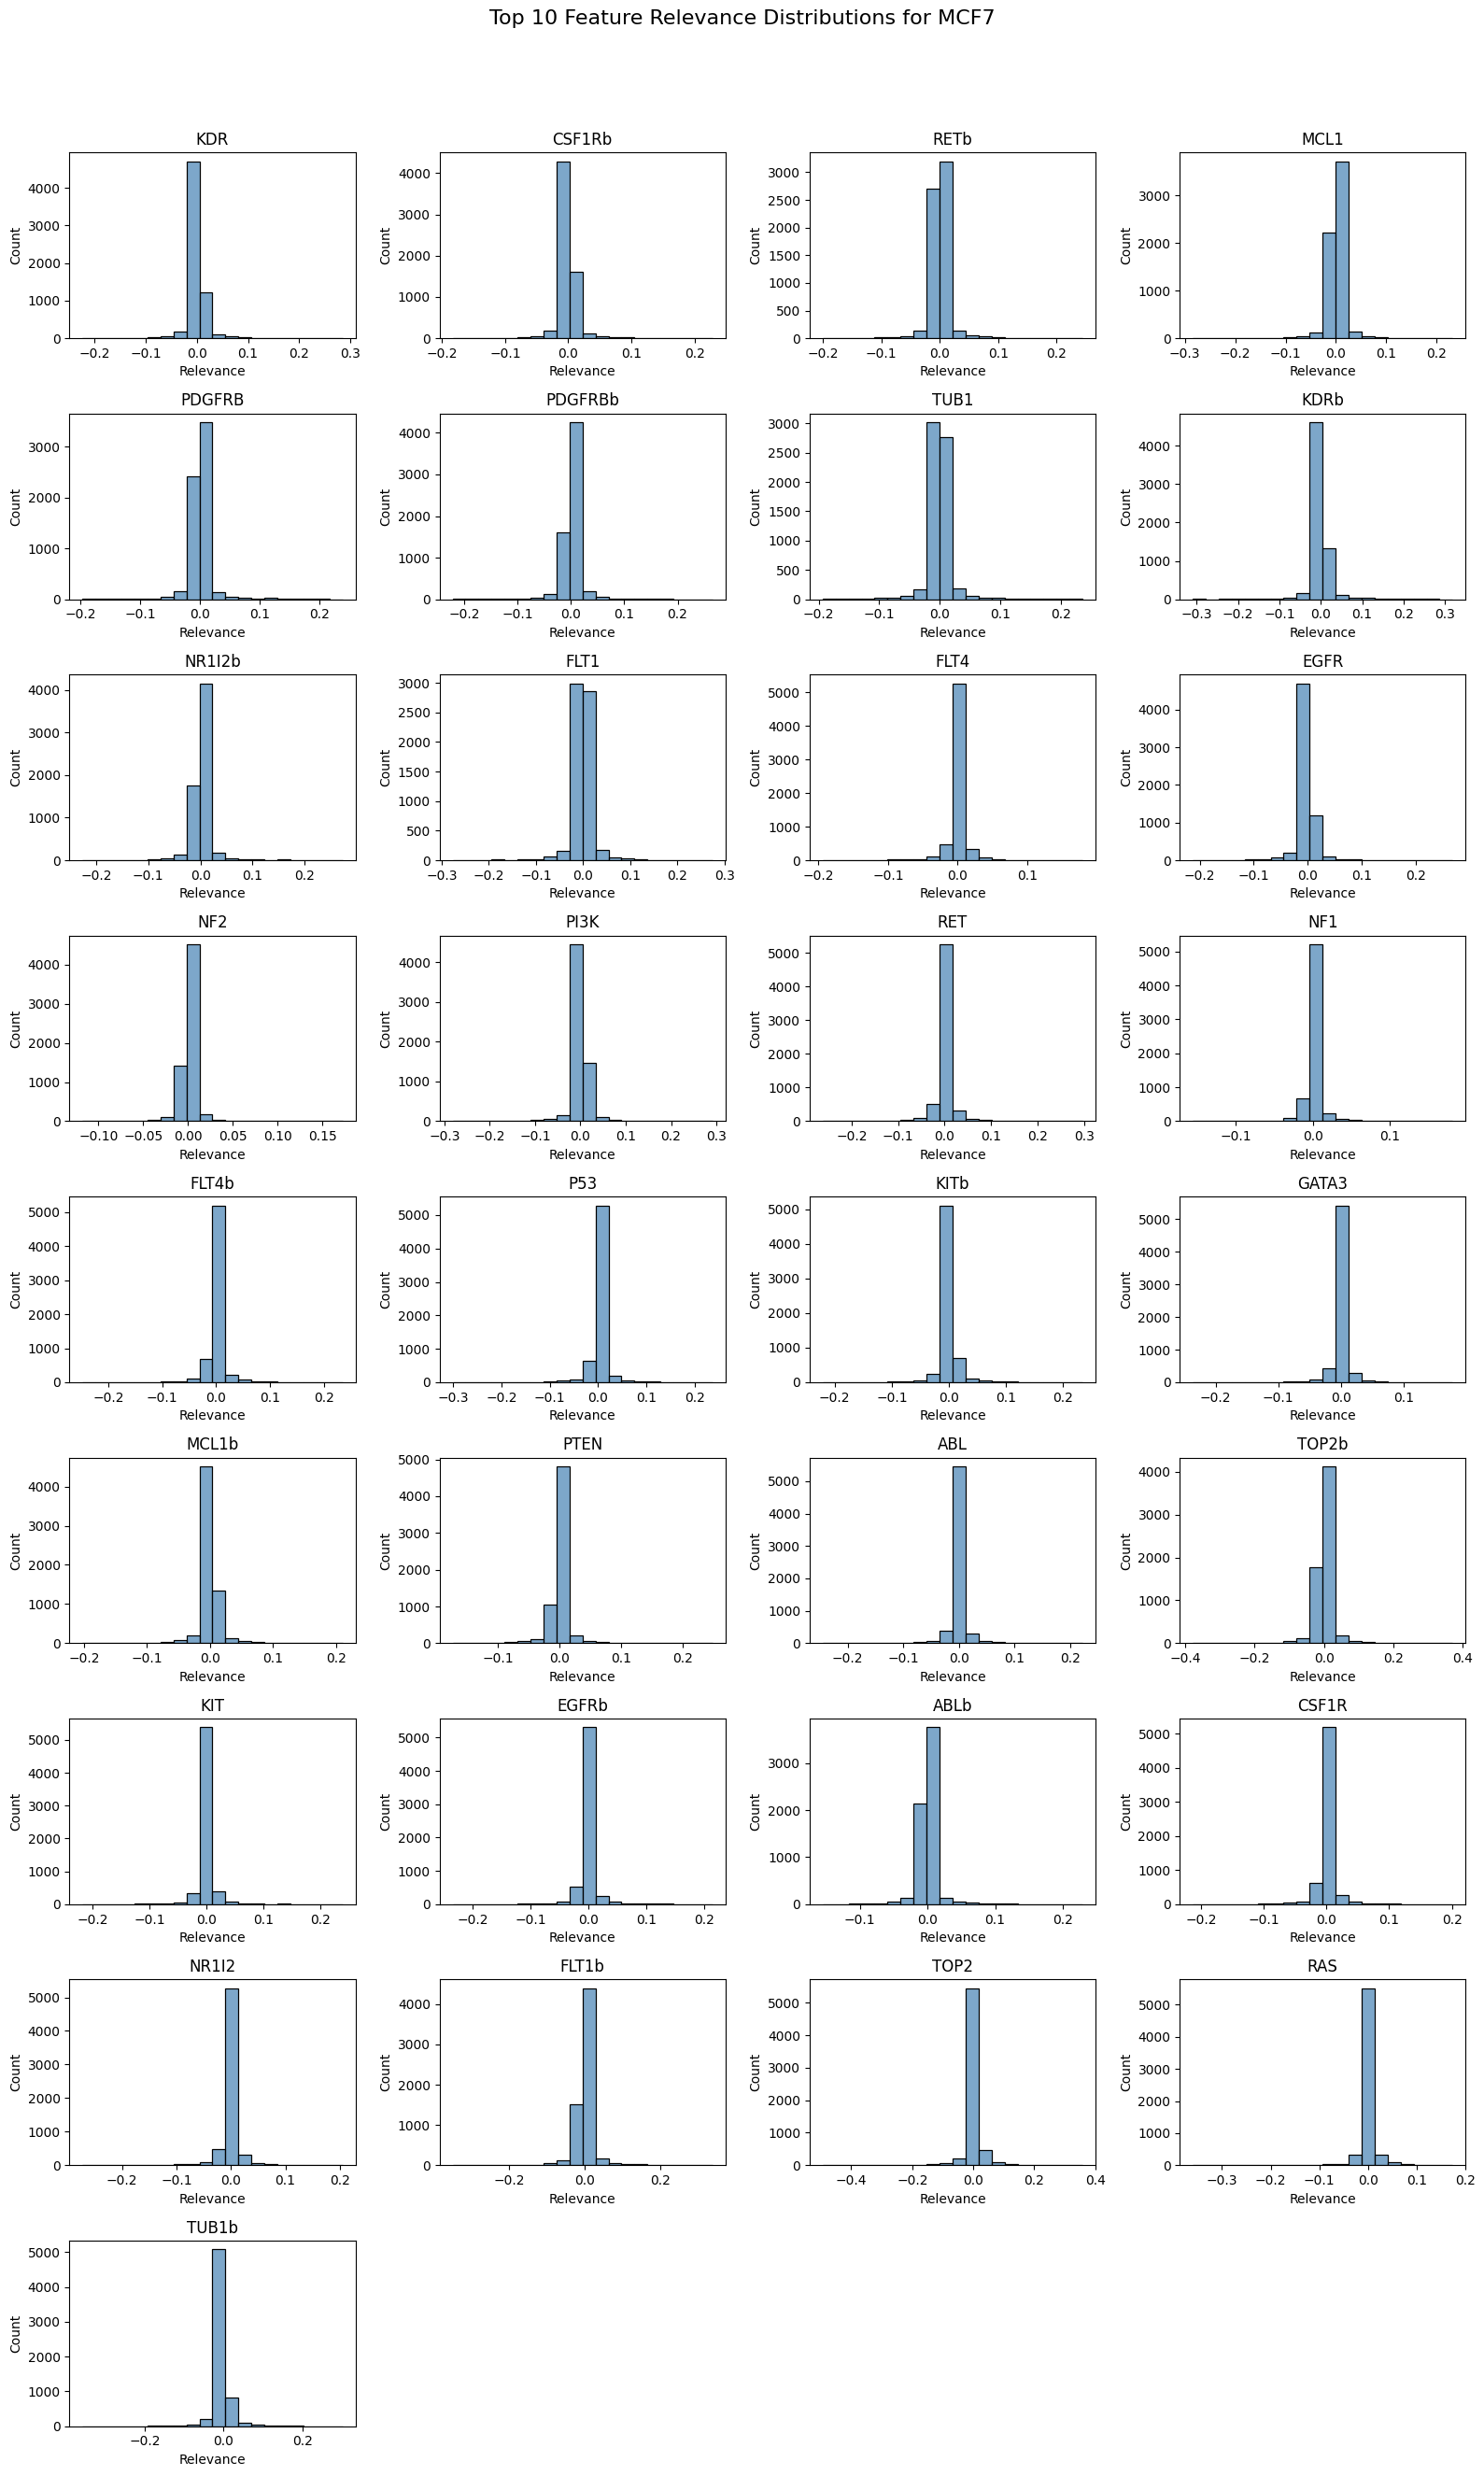

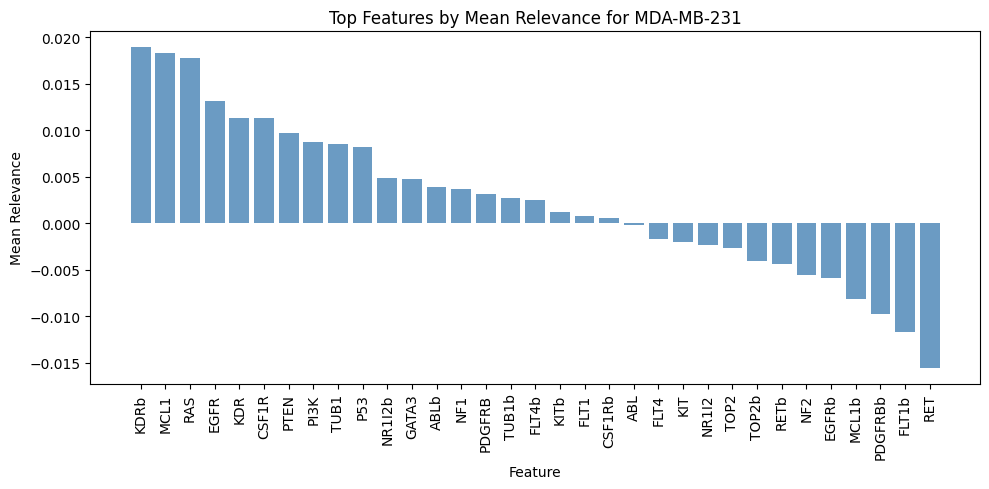

Number of samples for MDA-MB-231: 6476


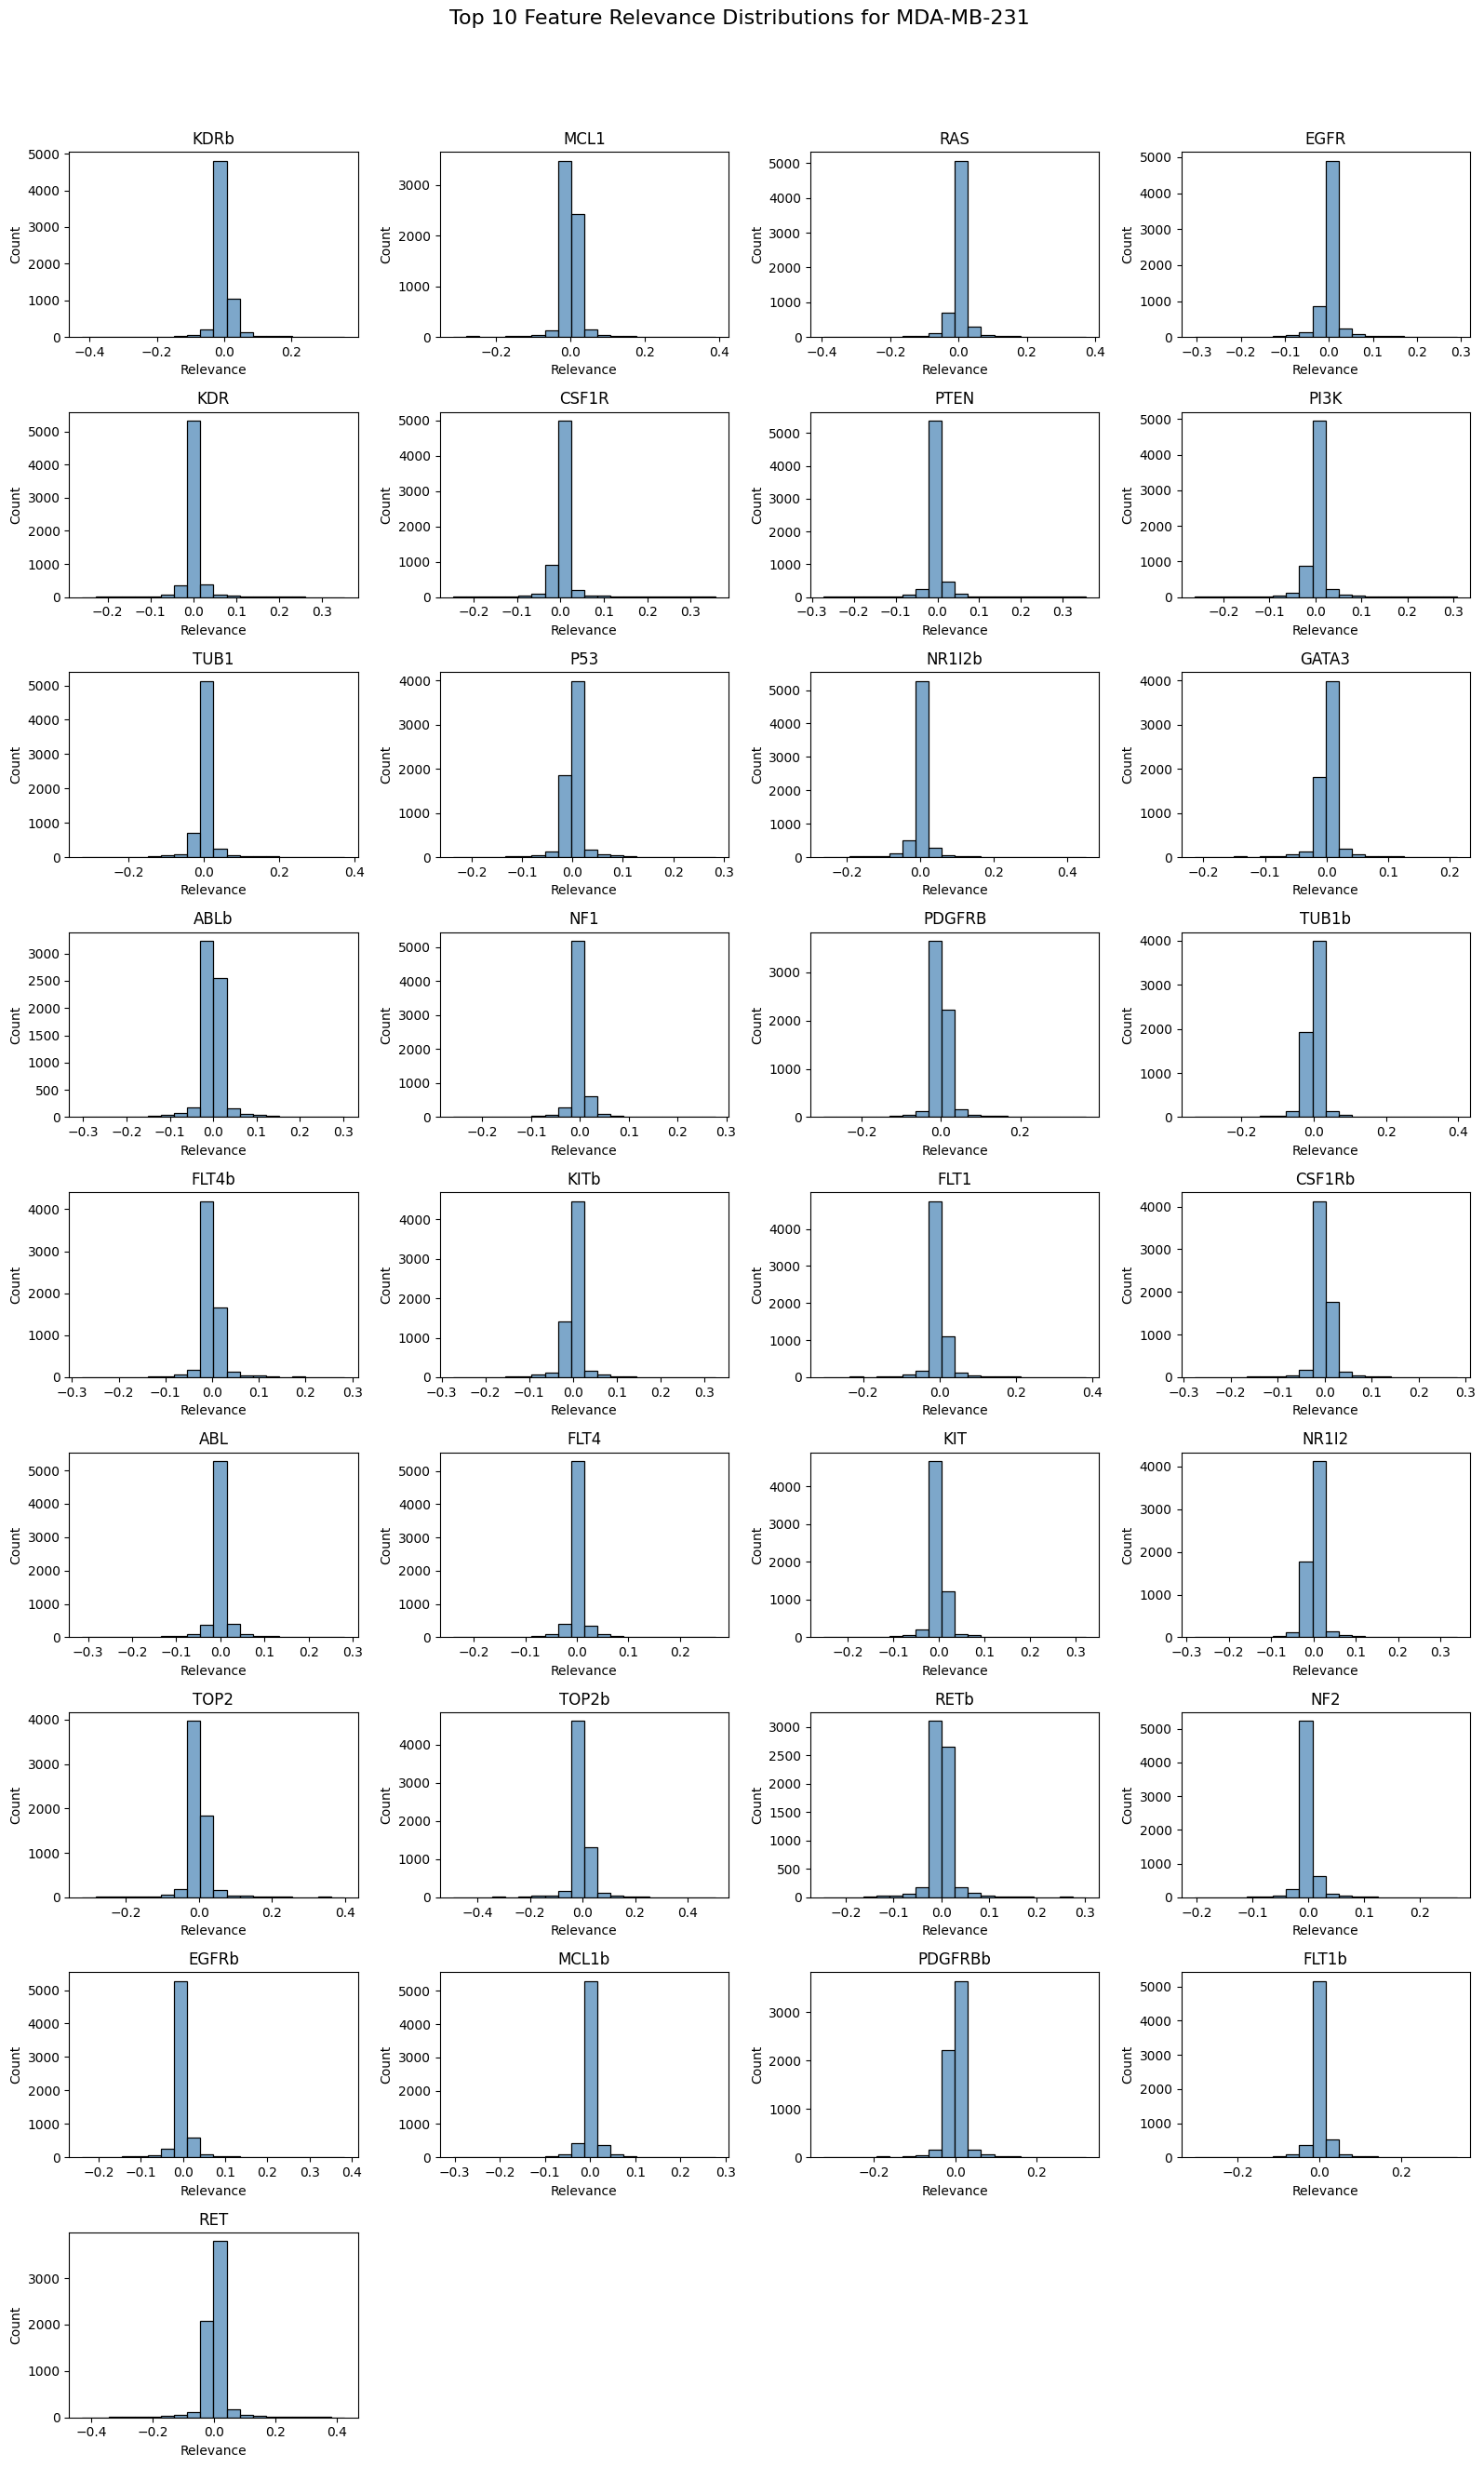

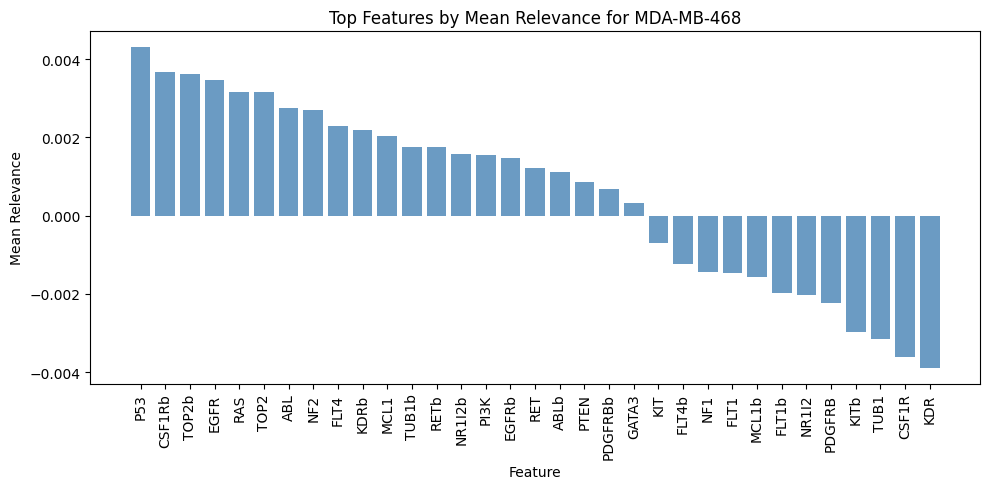

Number of samples for MDA-MB-468: 6400


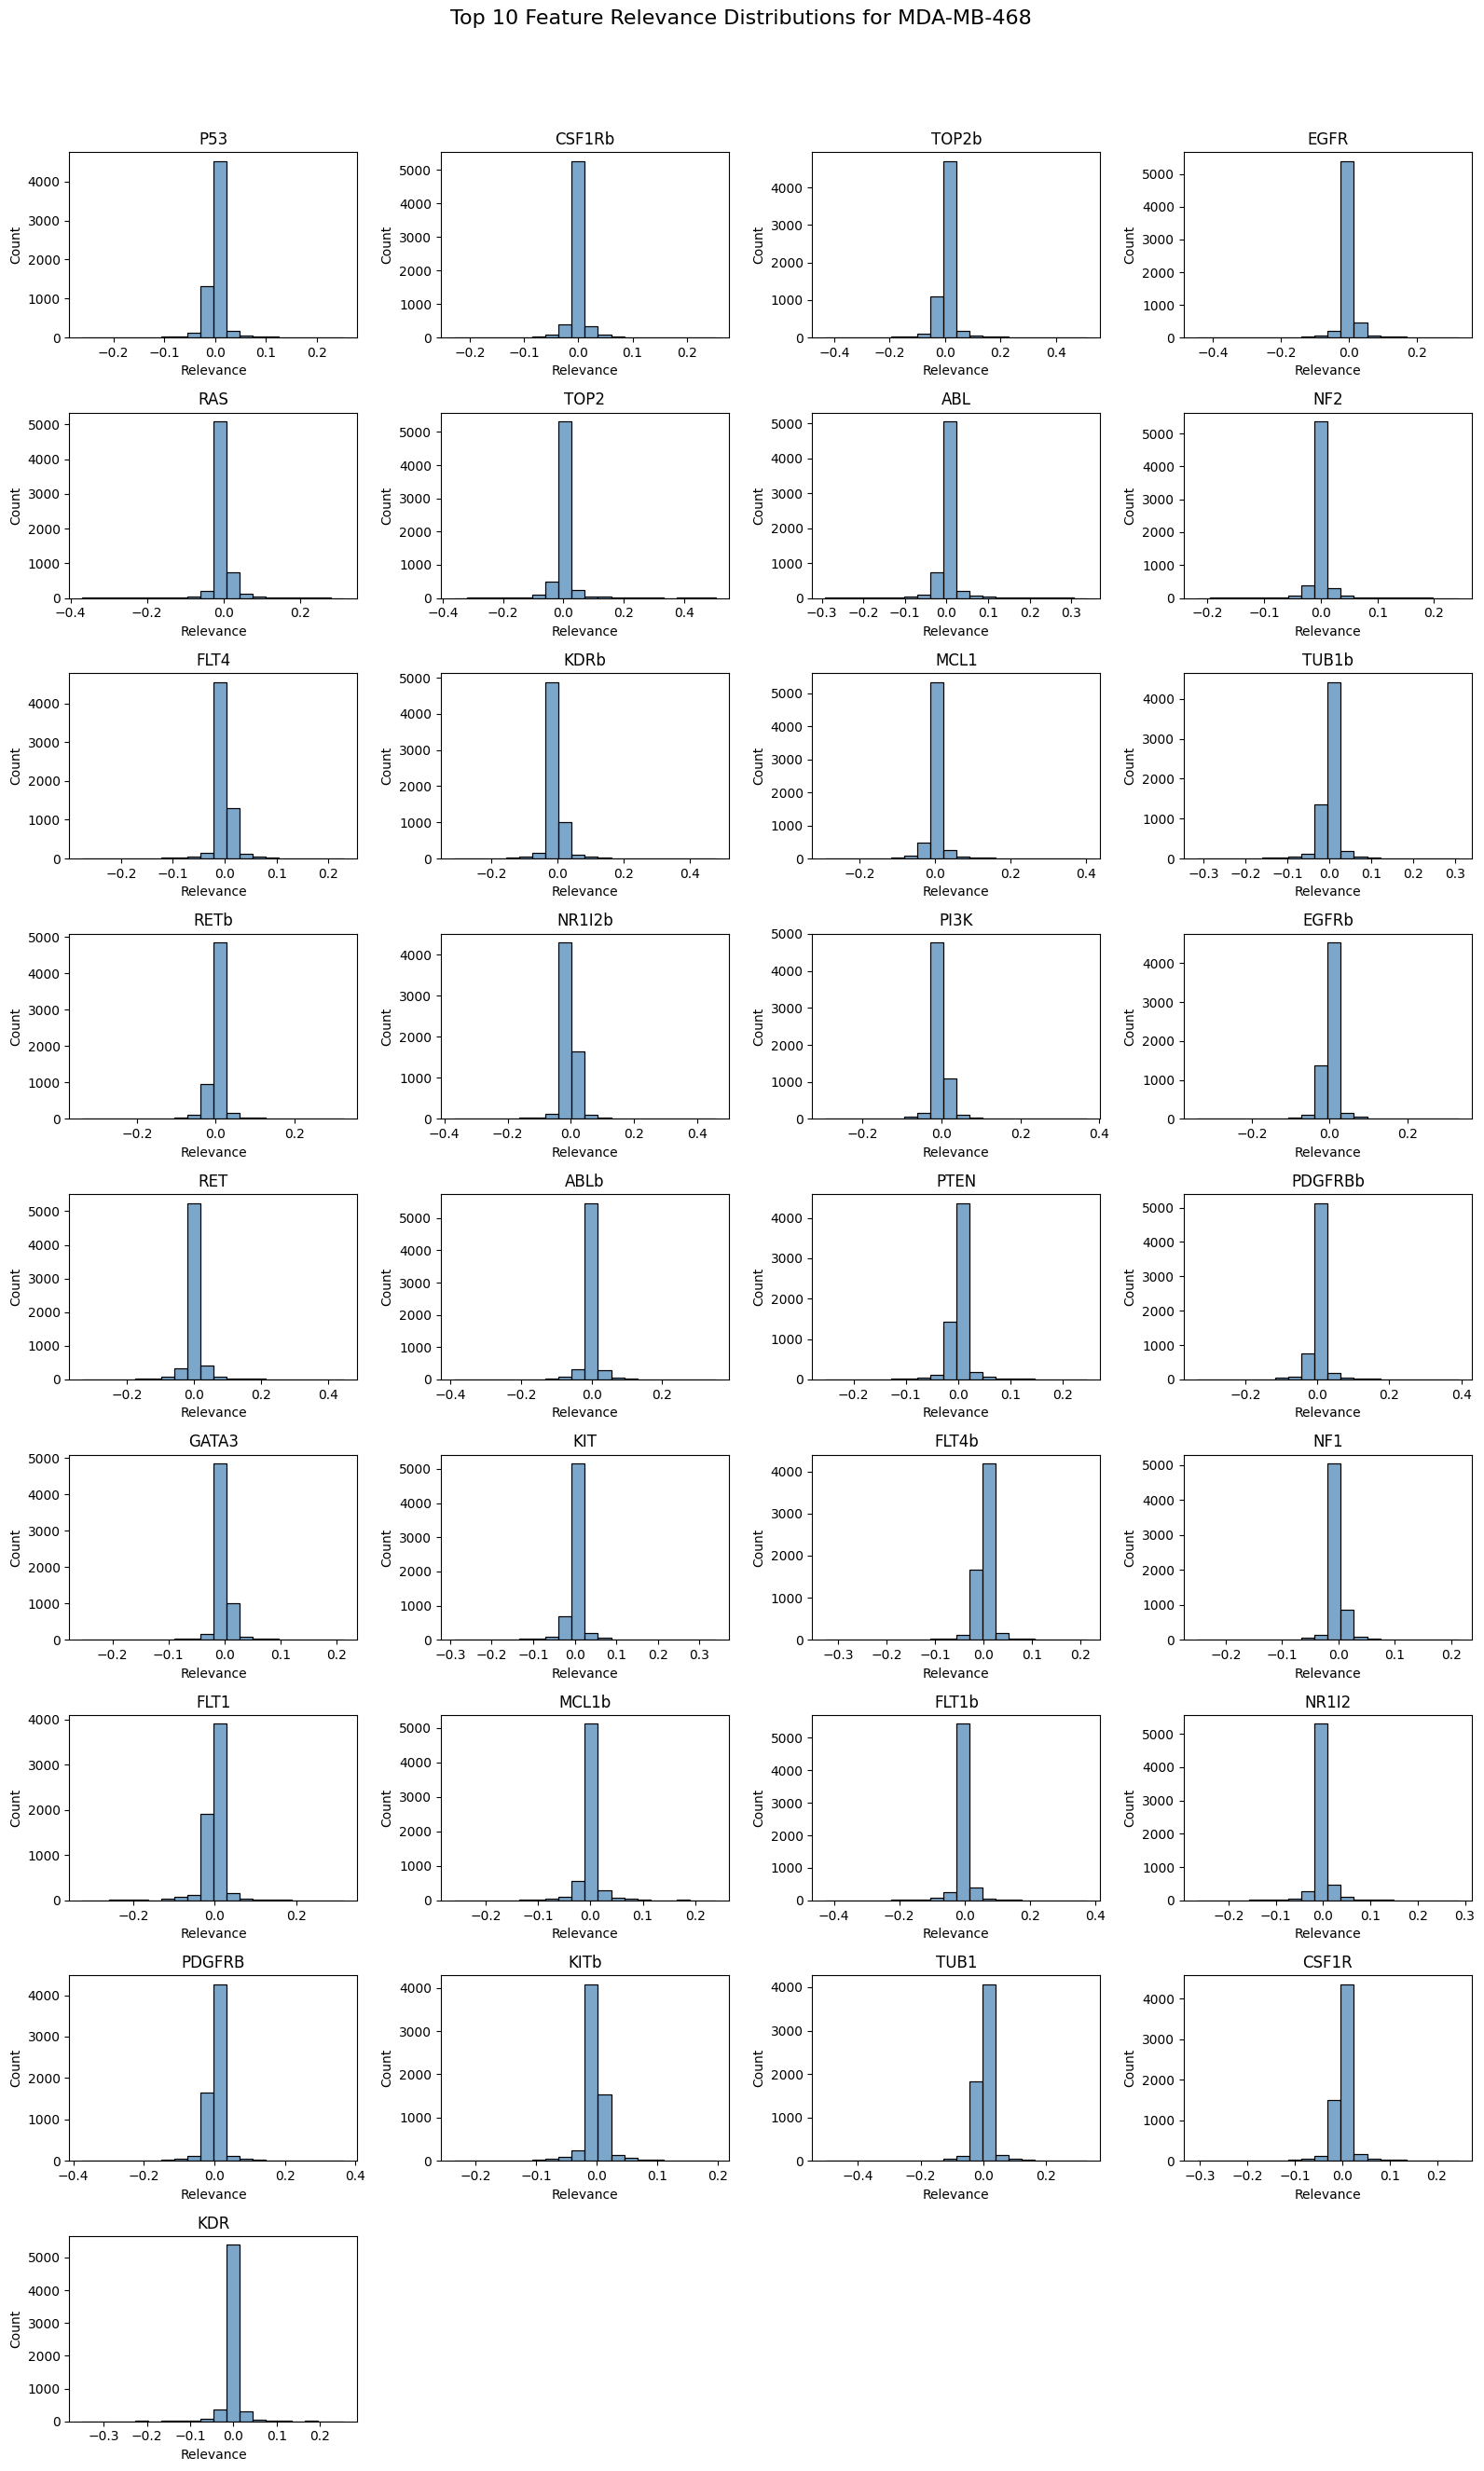

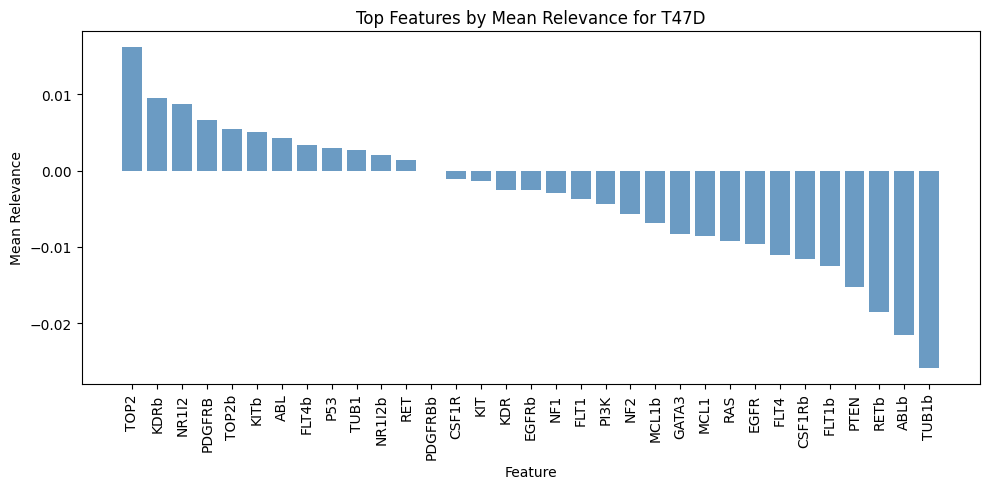

Number of samples for T47D: 6432


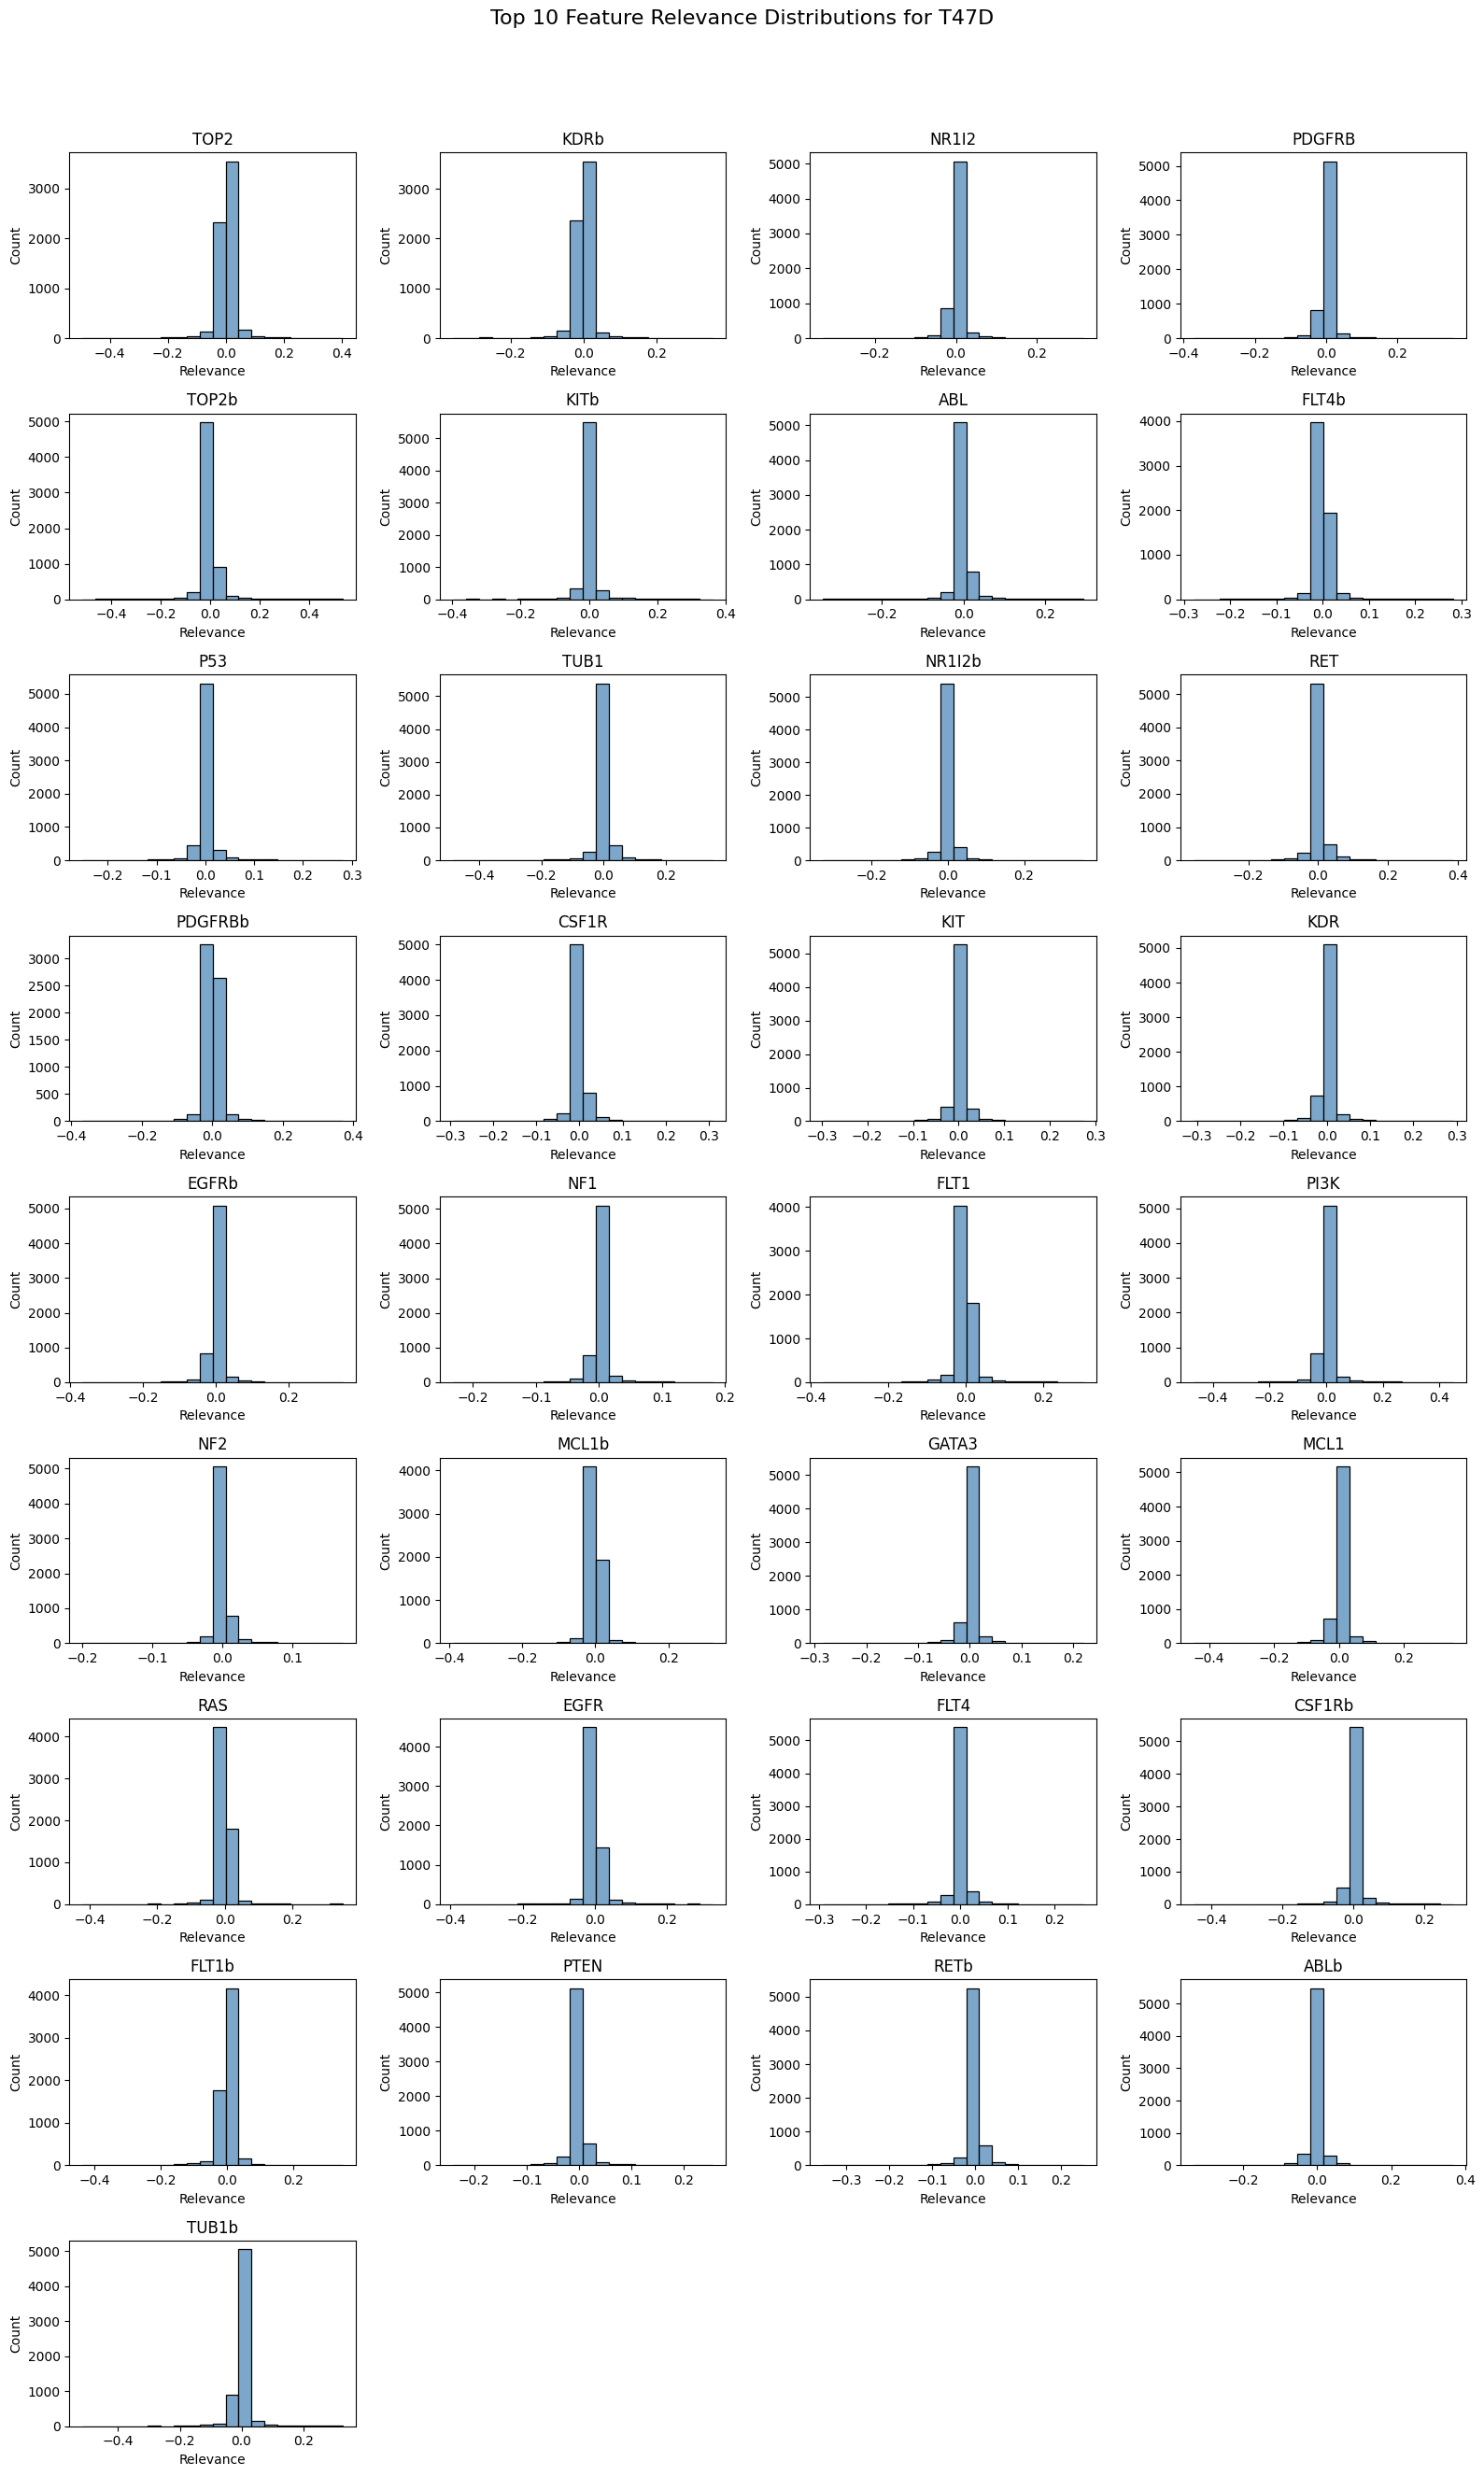

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def show_small_multiple_histograms(mask, title_suffix="", selected_features=None):
    relevances_filtered = relevances[mask]
    Y_filtered = Y[mask]
    y_values = np.array(Y_filtered).reshape(-1)
    print(f"Number of samples for {title_suffix}: {len(y_values)}")

    if len(y_values) == 0:
        print(f"Skipping {title_suffix} — no samples after filtering.")
        return

    if selected_features is None:
        features_to_plot = feature_names
    else:
        features_to_plot = selected_features

    data = pd.DataFrame(relevances_filtered, columns=feature_names)

    num_features = len(features_to_plot)
    ncols = 4
    nrows = (num_features + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=False, sharey=False)
    axes = axes.flatten()

    for i, feature in enumerate(features_to_plot):
        ax = axes[i]
        vmin = np.percentile(data[feature], 0.5)
        vmax = np.percentile(data[feature], 99.5)
        delta = (vmax - vmin) * 0.1 if vmax > vmin else 0.1
        sns.histplot(
            data[feature],
            bins=20,
            kde=False,
            ax=ax,
            color='steelblue',
            alpha=0.7,
            binrange=(vmin - delta, vmax + delta)
        )
        ax.set_title(feature)
        ax.set_xlabel("Relevance")
        ax.set_ylabel("Count")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f"Top 10 Feature Relevance Distributions for {title_suffix}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Usage:
cell_line_names = np.unique(cell_line_data)
for cell_line_name in cell_line_names:
    mask = cell_line_data == cell_line_name
    Y_cell_line = Y[mask]
    relevances_filtered = relevances[mask]
    means = np.mean(relevances_filtered, axis=0)

    # sort by bean relevance 
    features = np.array(feature_names)[np.argsort(means)[::-1]]
    means = means[np.argsort(means)[::-1]]
        
    plt.figure(figsize=(10, 5))
    plt.bar(features, means, color='steelblue', alpha=0.8)
    plt.xticks(rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Mean Relevance")
    plt.title(f"Top Features by Mean Relevance for {cell_line_name}")
    plt.tight_layout()
    plt.show()

    show_small_multiple_histograms(mask, title_suffix=cell_line_name, selected_features=features)


Number of samples for BT549: 2548


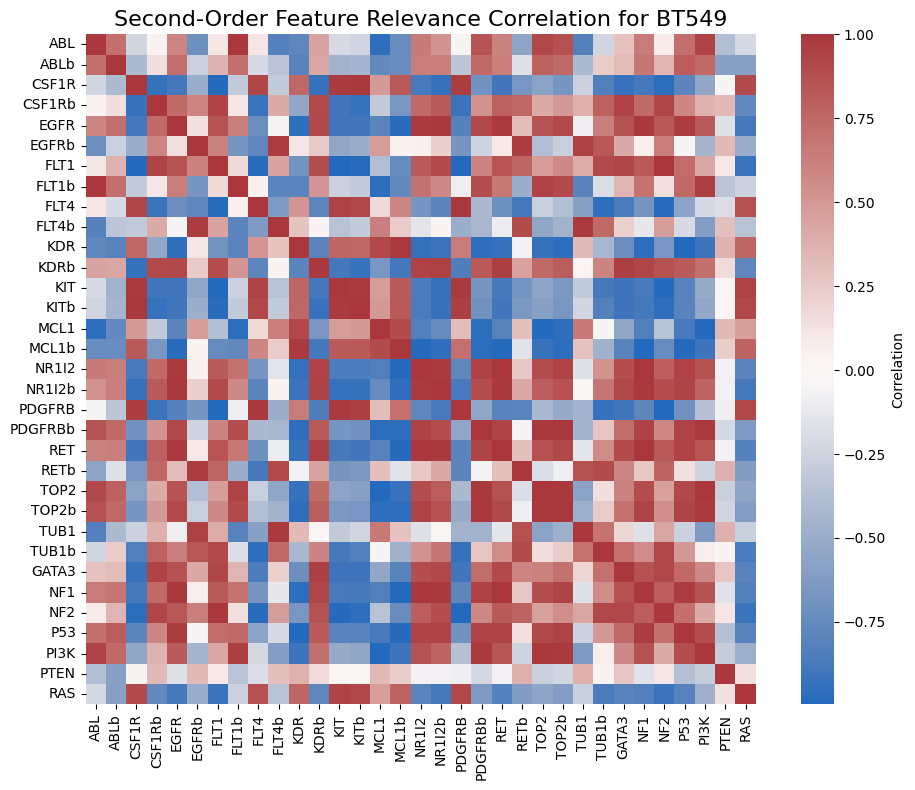

Number of samples for MCF7: 2196


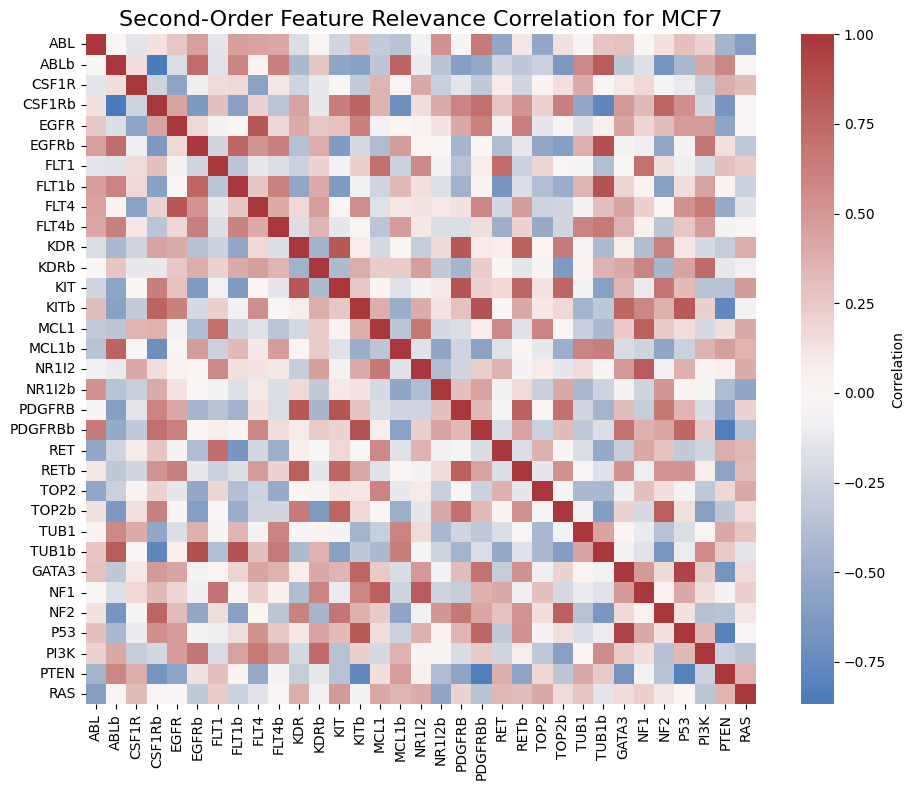

Number of samples for MDA-MB-231: 1764


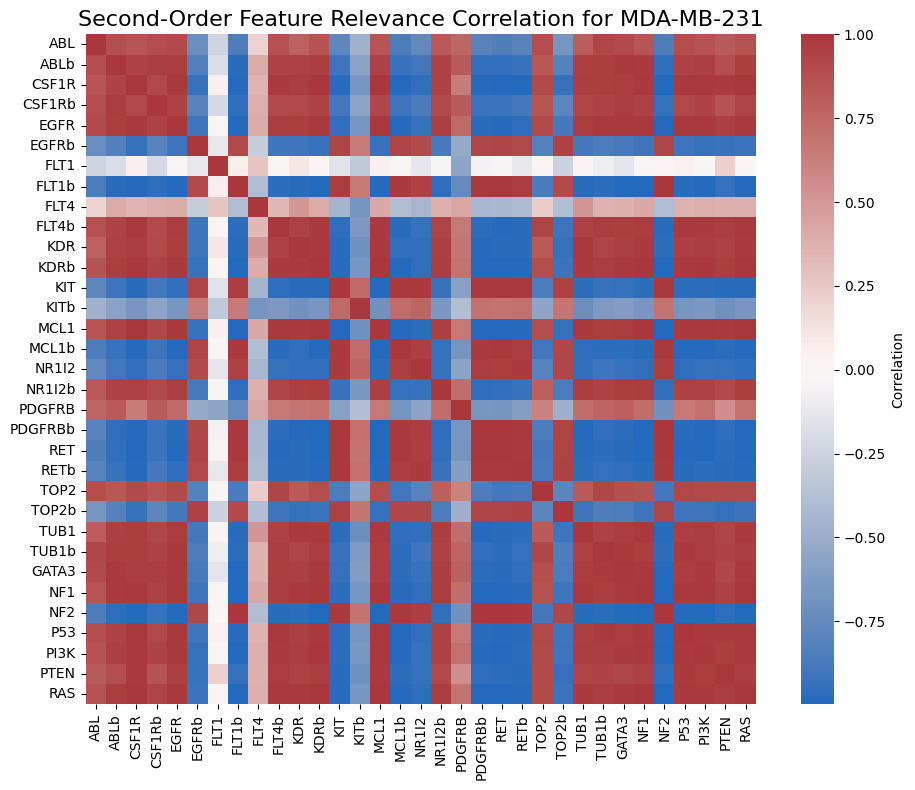

Number of samples for MDA-MB-468: 2484


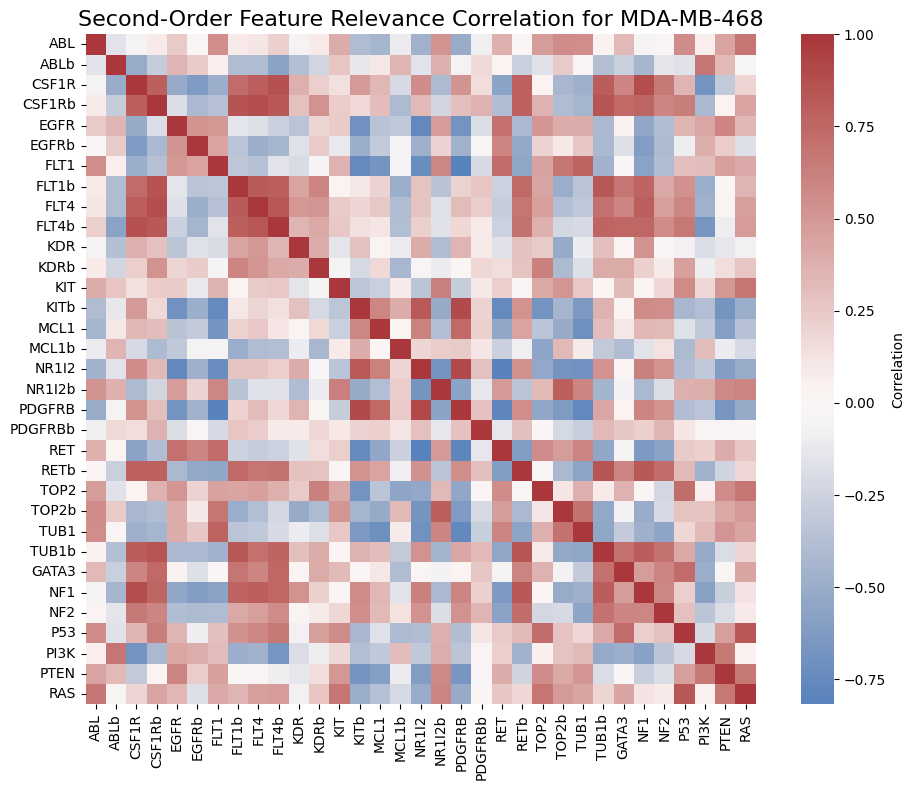

Number of samples for T47D: 2316


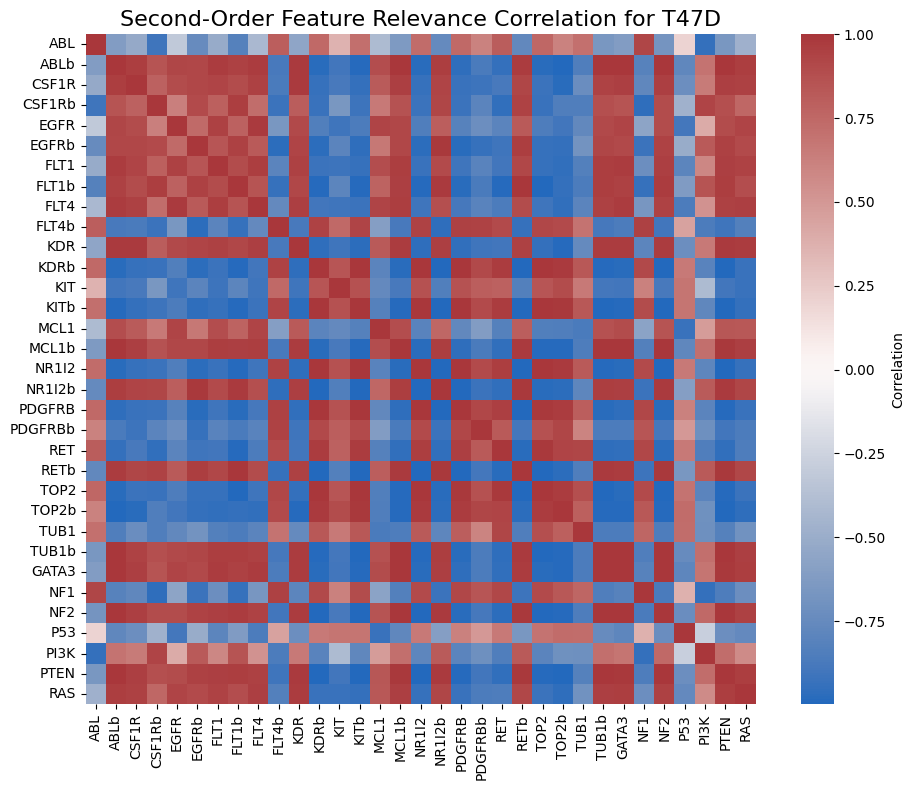

In [7]:
# get second order plot 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


def show_second_order_relevances(mask, title_suffix=""):
    relevances_filtered = relevances[mask]
    Y_filtered = Y[mask]
    y_values = np.array(Y_filtered).reshape(-1)

    if len(y_values) == 0:
        print(f"Skipping {title_suffix} — no samples after filtering.")
        return

    print(f"Number of samples for {title_suffix}: {len(y_values)}")

    df = pd.DataFrame(relevances_filtered, columns=feature_names)
    second_order = df.corr().fillna(0)

    plt.figure(figsize=(10, 8))
    sns.heatmap(second_order, cmap="vlag", center=0, square=True, cbar_kws={"label": "Correlation"})
    plt.title(f"Second-Order Feature Relevance Correlation for {title_suffix}", fontsize=16)
    plt.tight_layout()
    plt.show()


cell_line_names = np.unique(cell_line_data)
for cell_line_name in cell_line_names:
    mask = cell_line_data == cell_line_name
    positive_mask = Y > 0
    new_mask = mask & positive_mask
    show_second_order_relevances(new_mask, title_suffix=cell_line_name)


## Transynergy

See paper: file:///C:/Users/ismyn/Downloads/journal.pcbi.1008653.pdf

In [8]:
print(model_trans)

TransposeMultiTransformersPlusLinear(
  (linear_layers): ModuleList(
    (0-2): 3 x Linear(in_features=2402, out_features=400, bias=True)
  )
  (norms): ModuleList(
    (0-2): 3 x Norm()
  )
  (dropouts): ModuleList(
    (0-2): 3 x Dropout(p=0.2, inplace=False)
  )
  (transformer_list): ModuleList(
    (0): Transformer(
      (encoder): Encoder(
        (layers): ModuleList(
          (0): EncoderLayer(
            (norm_1): Norm()
            (norm_2): Norm()
            (attn): MultiHeadAttention(
              (q_linear): Linear(in_features=3, out_features=3, bias=True)
              (v_linear): Linear(in_features=3, out_features=3, bias=True)
              (k_linear): Linear(in_features=3, out_features=3, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
              (out): Linear(in_features=3, out_features=3, bias=True)
            )
            (ff): FeedForward(
              (linear_1): Linear(in_features=3, out_features=3, bias=True)
              (dropout): 